# Recap: Understanding the "Greengraph" Example

We now know enough to understand everything we did in [the initial example chapter on the "Greengraph"](https://alan-turing-institute.github.io/rse-course/html/module01_introduction_to_python/01_01_data_analysis_example.html) ([notebook](../module01_introduction_to_python/01_01_data_analysis_example.ipynb)). Go back to that part of the notes, and re-read the code. 

Now, we can even write it up into a class, and save it as a module. Remember that it is generally a better idea to create files in an editor or integrated development environment (IDE) rather than through the notebook!

## Classes for Greengraph

In [1]:
%%bash
#%%cmd (windows)
mkdir -p greengraph  # Create the folder for the module (on mac or linux)

In [2]:
%%writefile greengraph/graph.py
import numpy as np
import geopy
from .map import Map


class Greengraph:
    def __init__(self, start, end):
        self.start = start
        self.end = end
        self.geocoder = geopy.geocoders.Nominatim(user_agent="rsd-course")

    def geolocate(self, place):
        return self.geocoder.geocode(place, exactly_one=False)[0][1]

    def location_sequence(self, start, end, steps):
        lats = np.linspace(start[0], end[0], steps)
        longs = np.linspace(start[1], end[1], steps)
        return np.vstack([lats, longs]).transpose()

    def green_between(self, steps):
        return [
            Map(*location).count_green()
            for location in self.location_sequence(
                self.geolocate(self.start), self.geolocate(self.end), steps
            )
        ]

Overwriting greengraph/graph.py


In [3]:
%%writefile greengraph/map.py

import numpy as np
from io import BytesIO
import imageio as img
import requests


class Map:
    def __init__(
        self, lat, long, satellite=True, zoom=10, size=(400, 400), sensor=False
    ):
        base = "https://static-maps.yandex.ru/1.x/?"

        params = dict(
            z=zoom,
            size=str(size[0]) + "," + str(size[1]),
            ll=str(long) + "," + str(lat),
            l="sat" if satellite else "map",
            lang="en_US",
        )

        self.image = requests.get(
            base, params=params
        ).content  # Fetch our PNG image data
        content = BytesIO(self.image)
        self.pixels = img.imread(content)  # Parse our PNG image as a numpy array

    def green(self, threshold):
        # Use NumPy to build an element-by-element logical array
        greener_than_red = self.pixels[:, :, 1] > threshold * self.pixels[:, :, 0]
        greener_than_blue = self.pixels[:, :, 1] > threshold * self.pixels[:, :, 2]
        green = np.logical_and(greener_than_red, greener_than_blue)
        return green

    def count_green(self, threshold=1.1):
        return np.sum(self.green(threshold))

    def show_green(data, threshold=1.1):
        green = self.green(threshold)
        out = green[:, :, np.newaxis] * array([0, 1, 0])[np.newaxis, np.newaxis, :]
        buffer = BytesIO()
        result = img.imwrite(buffer, out, format="png")
        return buffer.getvalue()

Overwriting greengraph/map.py


In [4]:
%%writefile greengraph/__init__.py
from .graph import Greengraph

Overwriting greengraph/__init__.py


## Invoking our code and making a plot

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt
from greengraph import Greengraph

mygraph = Greengraph("New York", "Chicago")
data = mygraph.green_between(20)

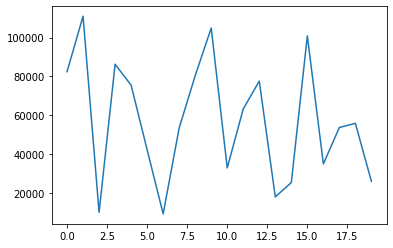

In [6]:
plt.plot(data)